In [1]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 52.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 104.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 25.5 MB/s eta 0:00:00


In [ ]:
seed = 48 # TODO: replace this with the random seed of your team!

# Note that this should be the general syntax and serves as a guidance,
# errors might appear because of the versions that these packages use

import numpy as np
np.random.seed(seed)
np.random.RandomState(seed)

import random
random.seed(seed)

import torch
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)

import tensorflow as tf
tf.random.set_seed(seed)
# tf.set_random_seed(seed)

import jax
jax.random.PRNGKey(seed)

RuntimeError: ignored

In [2]:
from __future__ import print_function, division
import os
import torch
import random
from torchvision.transforms import ToTensor, ToPILImage
import zipfile
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.utils.data import RandomSampler, Sampler
from torchvision import transforms, utils
import torch.nn as nn
from tqdm import tqdm
from typing import Iterator, List, Callable, Tuple
from functools import partial
from math import *
from IPython.display import HTML
from google.colab import files
import json

import pandas as pd
import string

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.animation as animation
%matplotlib notebook

from transformers import AutoTokenizer, AutoModel

# Importing stock ml libraries
import numpy as np
import pandas as pd
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig

# Preparing for TPU usage
# import torch_xla
# import torch_xla.core.xla_model as xm
# device = xm.xla_device()

In [3]:
! pip install -q kaggle
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c nitro-language-processing-2
! unzip nitro-language-processing-2.zip -d nitro-language-processing-2


Saving kaggle.json to kaggle.json
  0% 0.00/2.59M [00:00<?, ?B/s]
100% 2.59M/2.59M [00:00<00:00, 172MB/s]
Archive:  nitro-language-processing-2.zip
  inflating: nitro-language-processing-2/random_seed_setter.py  
  inflating: nitro-language-processing-2/random_seeds.csv  
  inflating: nitro-language-processing-2/sample_submission.csv  
  inflating: nitro-language-processing-2/test_data.csv  
  inflating: nitro-language-processing-2/train_data.csv  


In [4]:
train_file = pd.read_csv('/content/nitro-language-processing-2/train_data.csv')
test_file = pd.read_csv('/content/nitro-language-processing-2/test_data.csv')

In [ ]:
print(device)

NameError: ignored

In [5]:
train_file = train_file.drop(34257)
train_file = train_file.drop(33414)
train_file = train_file.drop(32609)
train_file = train_file.drop(31671)
train_file = train_file.drop(29515)
train_file = train_file.drop(27676)
train_file = train_file.drop(27463)
train_file = train_file.drop(26907)
train_file = train_file.drop(15495)
train_file = train_file.drop(15154)
train_file = train_file.drop(10025)
train_file = train_file.drop(2473)


train_data, val_data = train_test_split(train_file, test_size=0.2, shuffle=False)
train_data_texts = list(train_data["Text"])
val_data_texts = list(val_data["Text"])

test_data = list(test_file["Text"])

In [6]:
display(train_file[15000:])

,Text,Final Labels,Id
15002,@victore_1974 @claudiuciobanu Cei de la Pro nu...,non-offensive,15002
15003,Este cod galben de ploi în toată țara. La Cons...,non-offensive,15003
15004,"@Deedeeleemanca Nu conteaza ce se spala, conte...",non-offensive,15004
15005,@Manum_fnr @neacsufn si + am toate proofurile ...,non-offensive,15005
15006,bai eu ma intreb cum poti baga pe cineva ca de...,non-offensive,15006
...,...,...,...
39003,"@violetAndro @CorinaCg3 Așa e, știu atâtea exe...",non-offensive,39003
39004,"Directorul medical SAJ Galați, despre dispecer...",non-offensive,39004
39005,"Au ""invatat"" prostii de balta de la Satan ce e...",non-offensive,39005
39006,@_seriosul_ E o parte de adevar. Dar pana la u...,non-offensive,39006


In [7]:
# from transformers import BertTokenizer

# # Load the BERT tokenizer.
# print('Loading BERT tokenizer...')
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("dumitrescustefan/bert-base-romanian-cased-v1")
#tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [8]:
import re
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

In [10]:
import nltk

nltk.download('stopwords')

from nltk.corpus import stopwords

stop_words_nltk = set(stopwords.words('romanian'))

def remove_stop_words(text):
  preprocessed_text = []

  for word in text:
    if word not in stop_words_nltk:
      preprocessed_text.append(word)
  preprocessed_text = " ".join(preprocessed_text)

  return preprocessed_text

def remove_links_and_references(text):
  text_without_links = re.sub(r'http\S+', '', text)
  text_without_links = re.sub(r'www\S+', '', text_without_links)
  text_without_mentions = re.sub(r'@\w+','', text_without_links)
  text_without_hashtags = re.sub(r'#\w+','', text_without_mentions)

  return text_without_hashtags

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
pip install emoji --upgrade


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 KB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=190678d505111a080c2e060597ef1c11db17cbb4ccf2fa52b92bba36fcfcdffa
  Stored in directory: /root/.cache/pip/wheels/9a/b8/0f/f580817231cbf59f6ade9fd132ff60ada1de9f7dc85521f857
Successfully built emoji


In [12]:
import emoji
emoList = list(emoji.EMOJI_DATA.keys())
print(emoList)
from transformers import AutoTokenizer, AutoModel

# Load the BERT tokenizer.
tokenizer.add_tokens(emoList)

['🥇', '🥈', '🥉', '🆎', '🏧', '🅰️', '🅰', '🇦🇫', '🇦🇱', '🇩🇿', '🇦🇸', '🇦🇩', '🇦🇴', '🇦🇮', '🇦🇶', '🇦🇬', '♒', '🇦🇷', '♈', '🇦🇲', '🇦🇼', '🇦🇨', '🇦🇺', '🇦🇹', '🇦🇿', '🔙', '🅱️', '🅱', '🇧🇸', '🇧🇭', '🇧🇩', '🇧🇧', '🇧🇾', '🇧🇪', '🇧🇿', '🇧🇯', '🇧🇲', '🇧🇹', '🇧🇴', '🇧🇦', '🇧🇼', '🇧🇻', '🇧🇷', '🇮🇴', '🇻🇬', '🇧🇳', '🇧🇬', '🇧🇫', '🇧🇮', '🆑', '🆒', '🇰🇭', '🇨🇲', '🇨🇦', '🇮🇨', '♋', '🇨🇻', '♑', '🇧🇶', '🇰🇾', '🇨🇫', '🇪🇦', '🇹🇩', '🇨🇱', '🇨🇳', '🇨🇽', '🎄', '🇨🇵', '🇨🇨', '🇨🇴', '🇰🇲', '🇨🇬', '🇨🇩', '🇨🇰', '🇨🇷', '🇭🇷', '🇨🇺', '🇨🇼', '🇨🇾', '🇨🇿', '🇨🇮', '🇩🇰', '🇩🇬', '🇩🇯', '🇩🇲', '🇩🇴', '🔚', '🇪🇨', '🇪🇬', '🇸🇻', '🏴\U000e0067\U000e0062\U000e0065\U000e006e\U000e0067\U000e007f', '🇬🇶', '🇪🇷', '🇪🇪', '🇸🇿', '🇪🇹', '🇪🇺', '🆓', '🇫🇰', '🇫🇴', '🇫🇯', '🇫🇮', '🇫🇷', '🇬🇫', '🇵🇫', '🇹🇫', '🇬🇦', '🇬🇲', '♊', '🇬🇪', '🇩🇪', '🇬🇭', '🇬🇮', '🇬🇷', '🇬🇱', '🇬🇩', '🇬🇵', '🇬🇺', '🇬🇹', '🇬🇬', '🇬🇳', '🇬🇼', '🇬🇾', '🇭🇹', '🇭🇲', '🇭🇳', '🇭🇰', '🇭🇺', '🆔', '🇮🇸', '🇮🇳', '🇮🇩', '🇮🇷', '🇮🇶', '🇮🇪', '🇮🇲', '🇮🇱', '🇮🇹', '🇯🇲', '🇯🇵', '🉑', '🈸', '🉐', '🏯', '㊗️', '㊗', '🈹', '🎎', '🈚', '🈁', '🈷️', '🈷', '🈵', '🈶', '🈺', '🈴', '🏣', '🈲', '🈯', '㊙️', '㊙', '🈂️', '🈂', 

4729

In [13]:
train_dataset = list(train_data['Text'])

#train_dataset = train_dataset[:1001]
for i in range(len(train_dataset)):
  train_dataset[i] = remove_links_and_references(train_dataset[i])
  train_dataset[i] = train_dataset[i].translate(str.maketrans('', '', string.punctuation))
  #train_dataset[i] = emoji_pattern.sub(r'', train_dataset[i])
  train_dataset[i] = remove_stop_words(train_dataset[i].split())
  train_dataset[i] = ''.join([j for j in train_dataset[i] if not j.isdigit()])
#validation_dataset = NitroDataset(val_data)
print("Train dataset size: ", train_dataset[0])
#print("Validation dataset size: ", len(validation_dataset))

Train dataset size:  Încă trecut prin😃😃 fericită 👍🌺


In [14]:
print(train_dataset[2474])

Îi trimit mulți pupici persoanei ales setlist


In [ ]:
# Print the original sentence.
print(' Original: ', train_dataset[100])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(train_dataset[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train_dataset[100])))

 Original:  Idk editez gen trebuie fac mișto și probabil plictisesc primele  clip uri idk bn raman fn
Tokenized:  ['Încă', 'trecut', 'prin', '😃', '😃', 'fericită', '👍', '🌺']
Token IDs:  [30860, 219, 3780, 5648, 1059, 710, 1069, 17144, 377, 2476, 42202, 3184, 4481, 2097, 11229, 219, 70, 216, 31934, 74, 216]


In [ ]:
max_len = 0

# For every sentence...
for sent in train_dataset:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  113


In [15]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in train_dataset:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        truncation = True,
                        max_length = 128,           # Pad & truncate all sentences.
                        padding='max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
text_labels = list(train_data['Final Labels'])
#text_labels = text_labels[:1001]
labels = []
for label in text_labels:
      if label == "direct":
        labels.append(0)
      elif label == "descriptive":
        labels.append(1)
      elif label == "reporting":
        labels.append(2)
      elif label == "offensive":
        labels.append(3)
      elif label == "non-offensive":
        labels.append(4)

labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', len(train_dataset))
print('Token IDs:', input_ids)
print('Lables:', len(labels))

Original:  31196
Token IDs: tensor([[    2,  4913,  1488,  ...,     0,     0,     0],
        [    2, 21862,     3,  ...,     0,     0,     0],
        [    2,   753, 10973,  ...,     0,     0,     0],
        ...,
        [    2,  1724, 34111,  ...,     0,     0,     0],
        [    2,   788,  1201,  ...,     0,     0,     0],
        [    2,   782,   377,  ...,     0,     0,     0]])
Lables: 31196


In [16]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

28,076 training samples
3,120 validation samples


In [17]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 16
# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [18]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [19]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "dumitrescustefan/bert-base-romanian-cased-v1", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 5, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.resize_token_embeddings(len(tokenizer))
model.to(device)

Some weights of the model checkpoint at dumitrescustefan/bert-base-romanian-cased-v1 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClass

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(54729, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [20]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (54729, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

#MULTI CLASS

In [ ]:
!nvidia-smi

Sat Mar 25 23:57:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    27W /  70W |   1335MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [32]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

EPOCHS = 3
LEARNING_RATE = 3e-6

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer, 
             num_warmup_steps=0,
            num_training_steps=len(train_dataloader)*EPOCHS )

In [ ]:
!kill 1

In [33]:
ghe = torch.tensor([14,20,80,10,1.5])
ghe= ghe.to(device)
entro = nn.CrossEntropyLoss(ghe)

In [34]:
from torch.nn.utils import clip_grad_norm_
from tqdm.notebook import tqdm
import numpy as np
import math

train_loss_per_epoch = []
val_loss_per_epoch = []

torch.use_deterministic_algorithms(False)


for epoch_num in range(EPOCHS):
    print('Epoch: ', epoch_num + 1)
    '''
    Training
    '''
    model.train()
    train_loss = 0
    for step_num, batch_data in enumerate(tqdm(train_dataloader,desc='Training')):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)
        
        logit = output.logits
        loss = entro(logit,labels)
        train_loss += loss.item()

        model.zero_grad()
        loss.backward()
        del loss

        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    train_loss_per_epoch.append(train_loss / (step_num + 1))              


    '''
    Validation
    '''
    model.eval()
    valid_loss = 0
    valid_pred = []
    with torch.no_grad():
        for step_num_e, batch_data in enumerate(tqdm(validation_dataloader,desc='Validation')):
            input_ids, att_mask, labels = [data.to(device) for data in batch_data]
            output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

            loss = output.loss
            valid_loss += loss.item()
   
            valid_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))
        
    val_loss_per_epoch.append(valid_loss / (step_num_e + 1))
    valid_pred = np.concatenate(valid_pred)

    '''
    Loss message
    '''
    print("{0}/{1} train loss: {2} ".format(step_num+1, math.ceil(len(train_dataset) / batch_size), train_loss / (step_num + 1)))
    print("{0}/{1} val loss: {2} ".format(step_num_e+1, math.ceil(len(val_dataset) / batch_size), valid_loss / (step_num_e + 1)))

Epoch:  1


Training:   0%|          | 0/1755 [00:00<?, ?it/s]

Validation:   0%|          | 0/195 [00:00<?, ?it/s]

1755/878 train loss: 0.7858592732403523 
195/98 val loss: 0.6515416490725982 
Epoch:  2


Training:   0%|          | 0/1755 [00:00<?, ?it/s]

Validation:   0%|          | 0/195 [00:00<?, ?it/s]

1755/878 train loss: 0.6932963020356632 
195/98 val loss: 0.5890008732294425 
Epoch:  3


Training:   0%|          | 0/1755 [00:00<?, ?it/s]

Validation:   0%|          | 0/195 [00:00<?, ?it/s]

1755/878 train loss: 0.6303486651080287 
195/98 val loss: 0.5600360500506866 


In [ ]:
CUDA_LAUNCH_BLOCKING=1

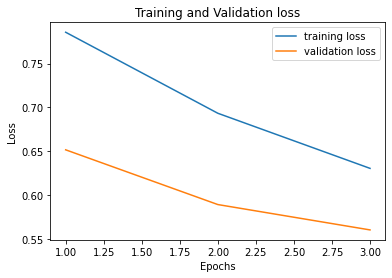

In [35]:
from matplotlib import pyplot as plt
%matplotlib inline
epochs = range(1, EPOCHS +1 )
fig, ax = plt.subplots()
ax.plot(epochs,train_loss_per_epoch,label ='training loss')
ax.plot(epochs, val_loss_per_epoch, label = 'validation loss' )
ax.set_title('Training and Validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

In [36]:
from sklearn.metrics import classification_report
print('classifiation report')
print(valid_pred)
print(labels)


classifiation report
[4 4 4 ... 3 3 4]
tensor([4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 3, 3, 4], device='cuda:0')


In [37]:
test_dataset = list(test_data)
#test_dataset = test_dataset[:50]
print(test_dataset[0])

for i in range(len(test_dataset)):
  test_dataset[i] = test_dataset[i].translate(str.maketrans('', '', string.punctuation))
  test_dataset[i] = emoji_pattern.sub(r'', test_dataset[i])
  test_dataset[i] = remove_stop_words(test_dataset[i].split())
  test_dataset[i] = ''.join([j for j in test_dataset[i] if not j.isdigit()])

În miezul ei se găsea un obiect ciudat , roz , răsucit , mărit de suprafața rotundă , care semăna cu un trandafir sau cu o anemonă de mare.


In [38]:
input_ids = []
attention_masks = []

# For every sentence...
for sent in test_dataset:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        truncation = True,
                        max_length = 128,           # Pad & truncate all sentences.
                        padding='max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
#print(len(attention_masks))
labels = [0] * len(test_dataset)
labels = torch.tensor(labels)
#print(len(labels))

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
test_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [42]:
model.eval()
test_pred = []
test_loss= 0
with torch.no_grad():
    for step_num, batch_data in tqdm(enumerate(test_dataloader)):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

        logit = output.logits
        loss = entro(logit,labels)
        test_loss += loss.item()
   
        test_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))
test_pred = np.concatenate(test_pred)

0it [00:00, ?it/s]

In [40]:
print(test_pred[0])

4


In [43]:
final_label_types = ["direct", "descriptive", "reporting", "offensive", "non-offensive"]

pred_labels = []
for test_label in test_pred:
  if test_label == 0:
    pred_labels.append("direct")
  elif test_label == 1:
    pred_labels.append("descriptive")
  elif test_label == 2:
    pred_labels.append("reporting")
  elif test_label == 3:
    pred_labels.append("offensive")
  elif test_label == 4:
    pred_labels.append("non-offensive")

fout = open("submission.csv", "w")
fout.write("Id,Label\n")
# fin = open("data/test.txt", "r")
# fin.readline()
# index = 0
# for test_img in fin:
#     fout.write(test_img.rstrip() + "," + str(int(predicted_labels[index])) + "\n")
#     index += 1
# fout.close()
# fin.close()

for i in range(len(pred_labels)):
  fout.write(str(i) + ',' + str(pred_labels[i]) + "\n")

fout.close()